In [28]:

import pandas as pd
import numpy as np
import nbimporter
import feature_engineering
from datetime import datetime, timedelta
from functools import reduce
import glob
import os
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

warnings.simplefilter(action='ignore', category=FutureWarning)

# 1. Preprocessing

In [2]:
%run Preprocessing.ipynb

## 1.1 Climate Data

### 1.1.1 Climate Data - Import 

In [3]:
climate_data = ["Temperature", "Precipitation"]
station_names = ["Berlin", "BW", "NRW"]
temp_path = r"C:\Users\Isabell\EMSI\emsi_ml\Wetter"
file_name = "produkt*"
date_column = "MESS_DATUM"
date_format = '%Y%m%d%H%M'

station_climate_list = []

for station in station_names:
    for data in climate_data:
        file_path =rf"{temp_path}\{station}\{data}"
        #print(file_path)
        temperature_dic = importing_climate_data(file_path, file_name, date_column, date_format)
        #print(temperature_dic)
        station_climate_list.append(temperature_dic)

print(station_climate_list[-1])
print("done")

{2012:         NRW_STATIONS_ID  NRW_MESS_DATUM  NRW_  QN  NRW_RWS_DAU_10  NRW_RWS_10  \
105120             2667    201201010000         3               0         0.0   
105121             2667    201201010010         3               2         0.0   
105122             2667    201201010020         3               8         0.0   
105123             2667    201201010030         3               7         0.0   
105124             2667    201201010040         3               1         0.0   
...                 ...             ...       ...             ...         ...   
157819             2667    201212312310         3               0         0.0   
157820             2667    201212312320         3               0         0.0   
157821             2667    201212312330         3               0         0.0   
157822             2667    201212312340         3               0         0.0   
157823             2667    201212312350         3               0         0.0   

        NRW_RWS_IND_

### 1.1.2 Climate Data - Downsampling to 15min steps

In [4]:
climate_resampled = []
for station in station_climate_list:
    resampled_dic = resampling_data(station, "15T")
    climate_resampled.append(resampled_dic)

print(climate_resampled[0])
print("done")

{2012:                      Berlin_STATIONS_ID  Berlin_MESS_DATUM  Berlin_  QN  \
DateTime                                                                  
2012-01-01 00:00:00               433.0       2.012010e+11          3.0   
2012-01-01 00:15:00               433.0       2.012010e+11          3.0   
2012-01-01 00:30:00               433.0       2.012010e+11          3.0   
2012-01-01 00:45:00               433.0       2.012010e+11          3.0   
2012-01-01 01:00:00               433.0       2.012010e+11          3.0   
...                                 ...                ...          ...   
2012-12-31 22:45:00               433.0       2.012123e+11          3.0   
2012-12-31 23:00:00               433.0       2.012123e+11          3.0   
2012-12-31 23:15:00               433.0       2.012123e+11          3.0   
2012-12-31 23:30:00               433.0       2.012123e+11          3.0   
2012-12-31 23:45:00               433.0       2.012123e+11          3.0   

                 

## 1.2 Football Data

### 1.2.1 Football Data - Importing

In [5]:

temp_path =r"Spielplan"
file_name = "*.csv"
date_column = "DateTime"
date_format = '%d. %b %y %H:%M'
other_date_format = '%d.%m.%Y %H:%M'



football_dic = importing_football_data(temp_path, file_name, date_column, date_format, other_date_format)
print(football_dic)

    

{2024:           Land1        Land2          Runde       Datum Uhrzeit (MESZ)  \
0   Deutschland   Schottland   Gruppenphase  14.06.2024          21:00   
1        Ungarn      Schweiz   Gruppenphase  15.06.2024          15:00   
2       Spanien     Kroatien   Gruppenphase  15.06.2024          18:00   
3       Italien     Albanien   Gruppenphase  15.06.2024          21:00   
4         Polen  Niederlande   Gruppenphase  16.06.2024          15:00   
5     Slowenien     Dänemark   Gruppenphase  16.06.2024          18:00   
6       Serbien      England   Gruppenphase  16.06.2024          21:00   
7      Rumänien      Ukraine   Gruppenphase  17.06.2024          15:00   
8       Belgien     Slowakei   Gruppenphase  17.06.2024          18:00   
9    Österreich   Frankreich   Gruppenphase  17.06.2024          21:00   
10       Türkei     Georgien   Gruppenphase  18.06.2024          18:00   
11     Portugal   Tschechien   Gruppenphase  18.06.2024          21:00   
12     Kroatien     Albanien   

### 1.2.2 Football Data - Adding new columns for Matches at same time

In [6]:

football_dic_new = {}
for key, match_set in football_dic.items():

    results = new_col_match(match_set)        
        
    results.set_index("DateTime")
    football_dic_new[key] = results

print(football_dic_new[2024])

             DateTime    Land1        Land2         Runde Liga       Land3  \
0 2024-06-23 21:00:00  Schweiz  Deutschland  Gruppenphase   EM  Schottland   

    Land4  
0  Ungarn  
          Land1        Land2         Runde Liga            DateTime  \
0   Deutschland   Schottland  Gruppenphase   EM 2024-06-14 21:00:00   
1        Ungarn      Schweiz  Gruppenphase   EM 2024-06-15 15:00:00   
2       Spanien     Kroatien  Gruppenphase   EM 2024-06-15 18:00:00   
3       Italien     Albanien  Gruppenphase   EM 2024-06-15 21:00:00   
4         Polen  Niederlande  Gruppenphase   EM 2024-06-16 15:00:00   
5     Slowenien     Dänemark  Gruppenphase   EM 2024-06-16 18:00:00   
6       Serbien      England  Gruppenphase   EM 2024-06-16 21:00:00   
7      Rumänien      Ukraine  Gruppenphase   EM 2024-06-17 15:00:00   
8       Belgien     Slowakei  Gruppenphase   EM 2024-06-17 18:00:00   
9    Österreich   Frankreich  Gruppenphase   EM 2024-06-17 21:00:00   
10       Türkei     Georgien  Gruppenp

## 1.3 Electricity Data

### 1.3.1 Electricity Data - Importing and converting MWh to floats

In [7]:
temp_path =r"Stromverbrauch\Viertel"
file_name = "*.csv"
date_column = "Datum von"
date_format = "%d.%m.%Y %H:%M"

elec_dic = importing_electricity_data(temp_path, file_name, date_column, date_format)



## 1.4 Merging Dataframes, dropping unwanted columns, filling nans with during match with data from football dataset

In [8]:
dfs = []

unwantend_col_string = ["QN", "MESS_DATUM", 'Datum von', 'Datum bis', "eor", "STATIONS"]
#print(climate_resampled)
for key, elec in elec_dic.items():
    football = football_dic_new[key]
    electricity = elec
    climate_data = []
    for station in climate_resampled:
        climate_data.append(pd.DataFrame(station[key])) 

    merged_df = merging_data(electricity, football, climate_data, unwantend_col_string)
                       
    dfs.append(merged_df)

endresult_df = pd.concat(dfs, ignore_index = True)

print(endresult_df)


       Gesamt (Netzlast) [MWh] Originalauflösungen            DateTime Land1  \
0                                         11930.50 2016-06-10 00:00:00   NaN   
1                                         11764.50 2016-06-10 00:15:00   NaN   
2                                         11602.50 2016-06-10 00:30:00   NaN   
3                                         11495.00 2016-06-10 00:45:00   NaN   
4                                         11384.25 2016-06-10 01:00:00   NaN   
...                                            ...                 ...   ...   
11323                                     12360.75 2024-07-11 22:45:00   NaN   
11324                                     12261.50 2024-07-11 23:00:00   NaN   
11325                                     12147.25 2024-07-11 23:15:00   NaN   
11326                                     11892.75 2024-07-11 23:30:00   NaN   
11327                                     11718.75 2024-07-11 23:45:00   NaN   

      Land2 Runde Liga Land3 Land4  Ber

# 2. Feature Engineering

In [9]:
%run feature_engineering.ipynb

## 2.1 Correlation matrix

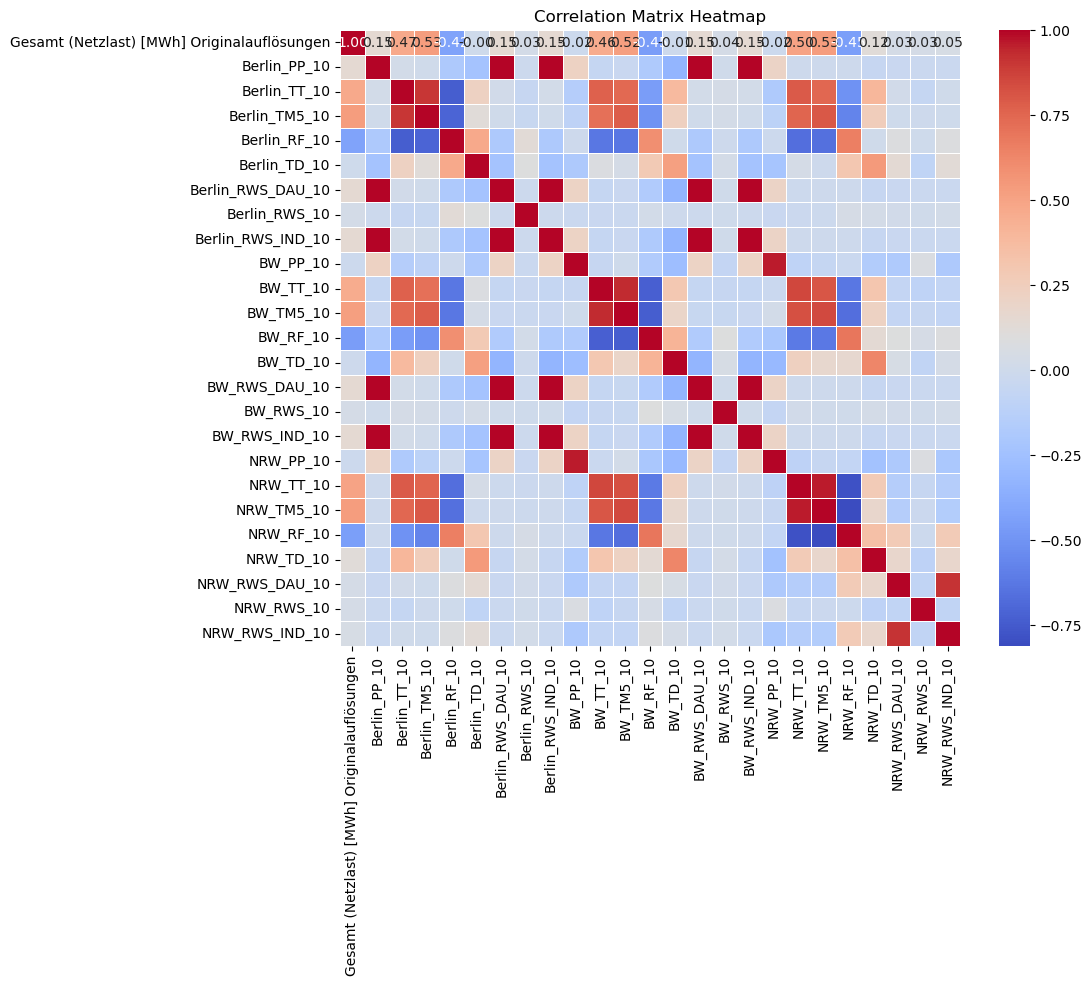

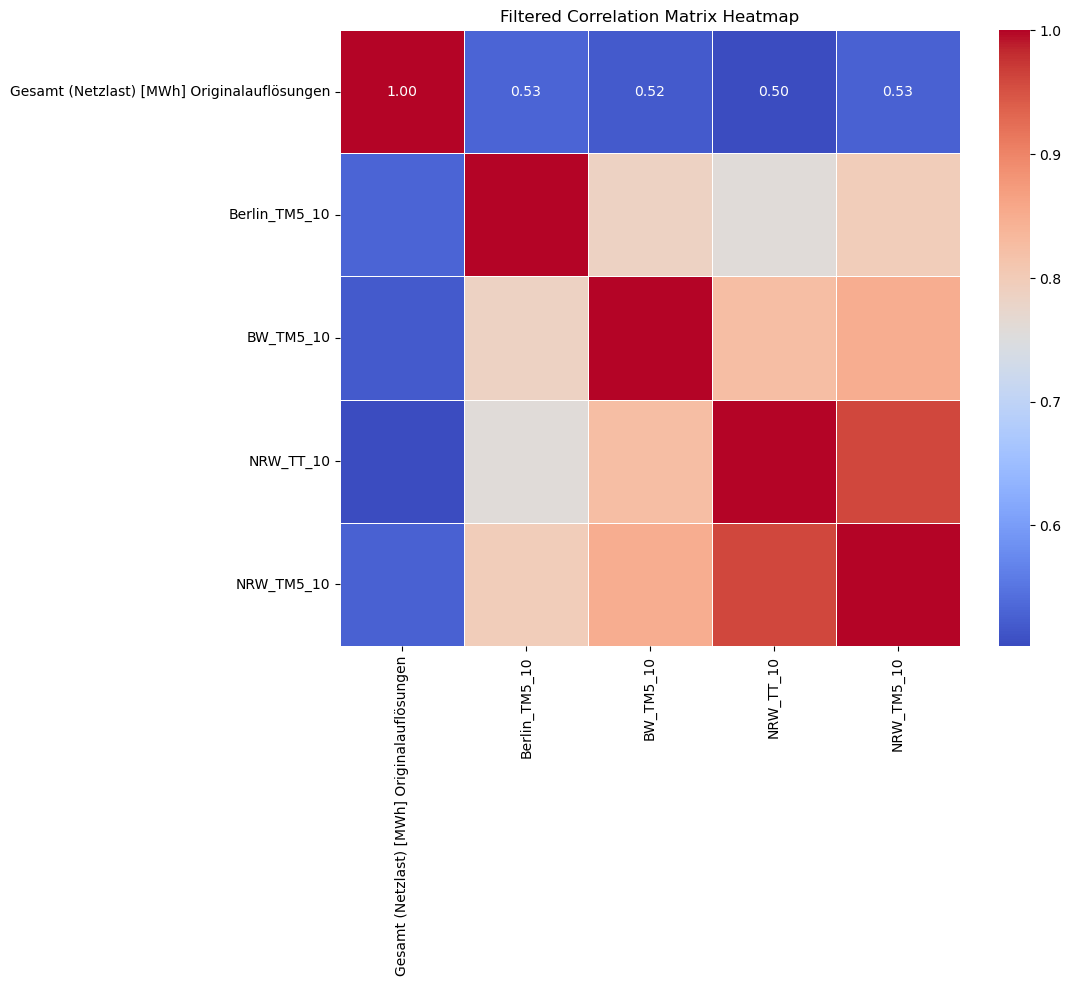

       Gesamt (Netzlast) [MWh] Originalauflösungen            DateTime Land1  \
0                                         11930.50 2016-06-10 00:00:00   NaN   
1                                         11764.50 2016-06-10 00:15:00   NaN   
2                                         11602.50 2016-06-10 00:30:00   NaN   
3                                         11495.00 2016-06-10 00:45:00   NaN   
4                                         11384.25 2016-06-10 01:00:00   NaN   
...                                            ...                 ...   ...   
11323                                     12360.75 2024-07-11 22:45:00   NaN   
11324                                     12261.50 2024-07-11 23:00:00   NaN   
11325                                     12147.25 2024-07-11 23:15:00   NaN   
11326                                     11892.75 2024-07-11 23:30:00   NaN   
11327                                     11718.75 2024-07-11 23:45:00   NaN   

      Land2 Runde Liga Land3 Land4  Ber

In [10]:
categorical_columns = ["Land1", "Land2", "Land3", "Land4", "Runde", "Liga", "DateTime"]
cut_off_limit = 0.5
#print(endresult_df)
#endresult_df.set_index("DateTime")
corr_df_input = endresult_df.copy()
df_filtered = correlation_matrix(corr_df_input, categorical_columns, cut_off_limit)
print(df_filtered)

## 2.2 Reducing dimensionality

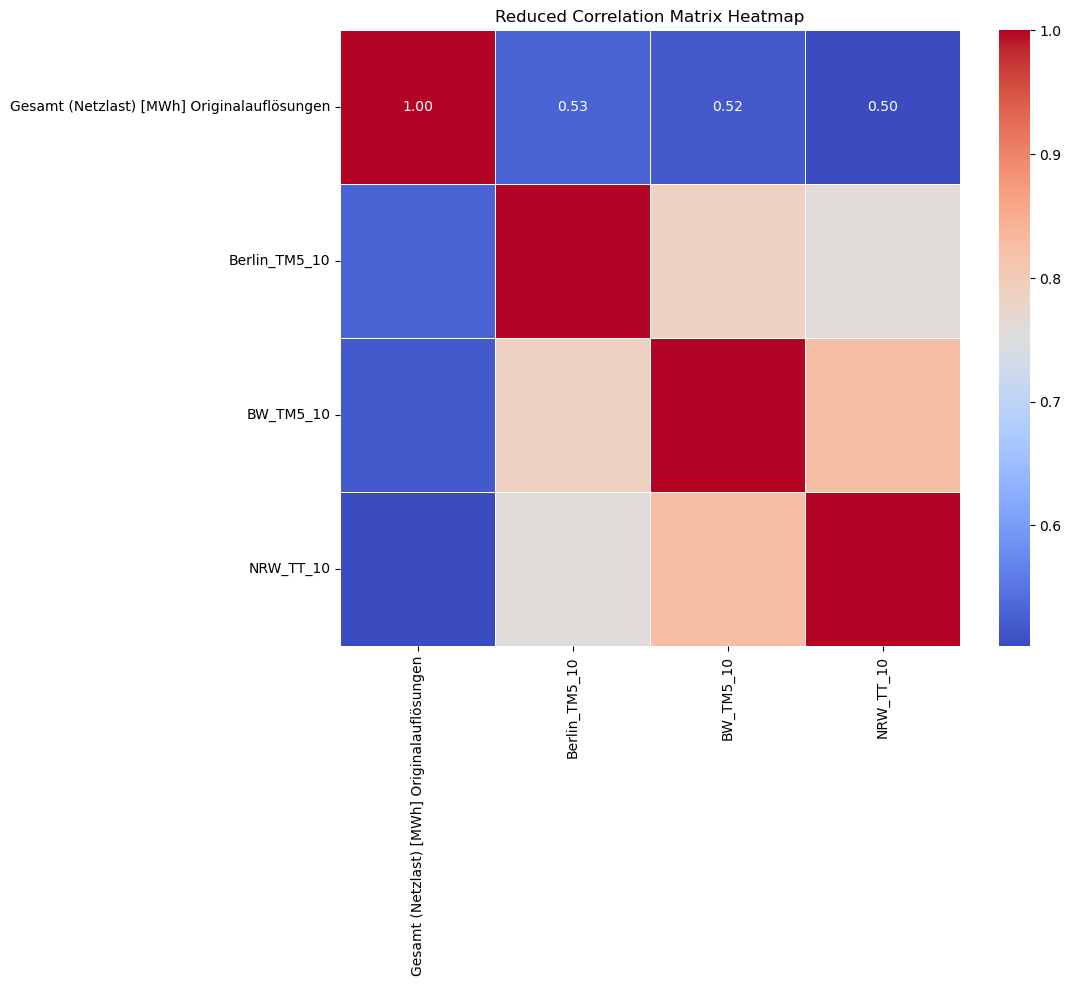

       Gesamt (Netzlast) [MWh] Originalauflösungen            DateTime Land1  \
0                                         11930.50 2016-06-10 00:00:00   NaN   
1                                         11764.50 2016-06-10 00:15:00   NaN   
2                                         11602.50 2016-06-10 00:30:00   NaN   
3                                         11495.00 2016-06-10 00:45:00   NaN   
4                                         11384.25 2016-06-10 01:00:00   NaN   
...                                            ...                 ...   ...   
11323                                     12360.75 2024-07-11 22:45:00   NaN   
11324                                     12261.50 2024-07-11 23:00:00   NaN   
11325                                     12147.25 2024-07-11 23:15:00   NaN   
11326                                     11892.75 2024-07-11 23:30:00   NaN   
11327                                     11718.75 2024-07-11 23:45:00   NaN   

      Land2 Runde Liga Land3 Land4  Ber

In [11]:
# Set the correlation threshold
correlation_threshold = 0.9 # Adjust this threshold as needed
categorical_columns = ["Land1", "Land2", "Land3", "Land4", "Runde", "Liga", "DateTime"]
#print(df_filtered)
reduce_input_df = df_filtered.copy()
df_reduced = reducing_dimensionality(df_filtered, correlation_threshold,categorical_columns)

print(df_reduced)

## 2.3 Normalizing Data 

In [13]:
categorical_columns = ["Land1", "Land2", "Land3", "Land4", "Runde", "Liga", "DateTime"]

columns_to_normalize = [col for col in df_reduced.columns if not any(excl in col for excl in categorical_columns)]
scaler = MinMaxScaler()
# Scale the entire dataframe
df_normalized = df_reduced.copy()
df_normalized[columns_to_normalize] = scaler.fit_transform(df_normalized[columns_to_normalize])



print(df_normalized)


       Gesamt (Netzlast) [MWh] Originalauflösungen            DateTime Land1  \
0                                         0.344068 2016-06-10 00:00:00   NaN   
1                                         0.327030 2016-06-10 00:15:00   NaN   
2                                         0.310402 2016-06-10 00:30:00   NaN   
3                                         0.299369 2016-06-10 00:45:00   NaN   
4                                         0.288002 2016-06-10 01:00:00   NaN   
...                                            ...                 ...   ...   
11323                                     0.388227 2024-07-11 22:45:00   NaN   
11324                                     0.378041 2024-07-11 23:00:00   NaN   
11325                                     0.366314 2024-07-11 23:15:00   NaN   
11326                                     0.340193 2024-07-11 23:30:00   NaN   
11327                                     0.322334 2024-07-11 23:45:00   NaN   

      Land2 Runde Liga Land3 Land4  Ber


## 1.8 Extracting Features out of DateTime

In [14]:
df_time_feature = df_normalized.copy()


df_time_feature['year'] = df_time_feature['DateTime'].dt.year
df_time_feature['month'] = df_time_feature['DateTime'].dt.month
df_time_feature['day'] = df_time_feature['DateTime'].dt.day
df_time_feature['hour'] = df_time_feature['DateTime'].dt.hour
df_time_feature['minute'] = df_time_feature['DateTime'].dt.minute
df_time_feature['day_of_week'] = df_time_feature['DateTime'].dt.dayofweek
df_time_feature['week_of_year'] = df_time_feature['DateTime'].dt.isocalendar().week
df_time_feature['is_weekend'] = df_time_feature['DateTime'].dt.weekday.apply(lambda x: 1 if x >= 5 else 0)
df_time_feature.drop(columns = ["DateTime"], inplace = True)
# Drop original datetime if you won't need it
print(df_time_feature)

       Gesamt (Netzlast) [MWh] Originalauflösungen Land1 Land2 Runde Liga  \
0                                         0.344068   NaN   NaN   NaN  NaN   
1                                         0.327030   NaN   NaN   NaN  NaN   
2                                         0.310402   NaN   NaN   NaN  NaN   
3                                         0.299369   NaN   NaN   NaN  NaN   
4                                         0.288002   NaN   NaN   NaN  NaN   
...                                            ...   ...   ...   ...  ...   
11323                                     0.388227   NaN   NaN   NaN  NaN   
11324                                     0.378041   NaN   NaN   NaN  NaN   
11325                                     0.366314   NaN   NaN   NaN  NaN   
11326                                     0.340193   NaN   NaN   NaN  NaN   
11327                                     0.322334   NaN   NaN   NaN  NaN   

      Land3 Land4  Berlin_TM5_10  BW_TM5_10  NRW_TT_10  year  month  day  \

## 1.5 Encoding categorical values

### 1.5.1 One-Hot Encoding

In [15]:
hot_encoded_df = df_time_feature.copy()
categorical_columns = ["Runde", "Liga"]
hot_encoded_df = pd.get_dummies(hot_encoded_df, columns = categorical_columns)
print(hot_encoded_df)

       Gesamt (Netzlast) [MWh] Originalauflösungen Land1 Land2 Land3 Land4  \
0                                         0.344068   NaN   NaN   NaN   NaN   
1                                         0.327030   NaN   NaN   NaN   NaN   
2                                         0.310402   NaN   NaN   NaN   NaN   
3                                         0.299369   NaN   NaN   NaN   NaN   
4                                         0.288002   NaN   NaN   NaN   NaN   
...                                            ...   ...   ...   ...   ...   
11323                                     0.388227   NaN   NaN   NaN   NaN   
11324                                     0.378041   NaN   NaN   NaN   NaN   
11325                                     0.366314   NaN   NaN   NaN   NaN   
11326                                     0.340193   NaN   NaN   NaN   NaN   
11327                                     0.322334   NaN   NaN   NaN   NaN   

       Berlin_TM5_10  BW_TM5_10  NRW_TT_10  year  month  ...  w

### 1.5.2 Ordinal Encoding

In [16]:
#print(football_dic)

temp_path =r"Spielplan"
file_name = "*.csv"
date_column = "DateTime"
date_format = '%d. %b %y %H:%M'
other_date_format = '%d.%m.%Y %H:%M'

football_dic_copy = importing_football_data(temp_path, file_name, date_column, date_format, other_date_format)

country_to_rank = ranking_countries_by_viewership(football_dic_copy)

encoding_columns = ["Land1", "Land2", "Land3", "Land4"]

ordinal_encoded_df = hot_encoded_df.copy()
for column in encoding_columns:
    ordinal_encoded_df[f'{column}_rank'] = ordinal_encoded_df[column].map(country_to_rank)
    
print(ordinal_encoded_df.columns)

df_encoded = ordinal_encoded_df.drop(columns= encoding_columns)
print(len(df_encoded.columns))

df_2024 = df_encoded[df_encoded['year'] == 2024]
deviation_factor = 0.05  # 5% deviation

# Apply Gaussian noise to each value
# The noise will have mean 0 and standard deviation = deviation_factor * actual value
#df_predictions = df_2024.apply(lambda x: x + np.random.normal(0, deviation_factor * x))
# Optionally, create another DataFrame that contains the rows where 'year' is not 2024
df_not_2024 = df_encoded[df_encoded['year'] != 2024]

#print(df_2024)
print(df_not_2024.columns)

Index(['Gesamt (Netzlast) [MWh] Originalauflösungen', 'Land1', 'Land2',
       'Land3', 'Land4', 'Berlin_TM5_10', 'BW_TM5_10', 'NRW_TT_10', 'year',
       'month', 'day', 'hour', 'minute', 'day_of_week', 'week_of_year',
       'is_weekend', 'Runde_Achtelfinale', 'Runde_Finale',
       'Runde_Gruppenphase', 'Runde_Halbfinale', 'Runde_Spiel um Platz 3',
       'Runde_Viertelfinale', 'Liga_EM', 'Liga_WM', 'Land1_rank', 'Land2_rank',
       'Land3_rank', 'Land4_rank'],
      dtype='object')
24
Index(['Gesamt (Netzlast) [MWh] Originalauflösungen', 'Berlin_TM5_10',
       'BW_TM5_10', 'NRW_TT_10', 'year', 'month', 'day', 'hour', 'minute',
       'day_of_week', 'week_of_year', 'is_weekend', 'Runde_Achtelfinale',
       'Runde_Finale', 'Runde_Gruppenphase', 'Runde_Halbfinale',
       'Runde_Spiel um Platz 3', 'Runde_Viertelfinale', 'Liga_EM', 'Liga_WM',
       'Land1_rank', 'Land2_rank', 'Land3_rank', 'Land4_rank'],
      dtype='object')


### 1.5.3 Cyclic Encoding

In [33]:

categorical_columns = ["Land1", "Land2", "Land3", "Land4", "Runde", "Liga", "DateTime"]
columns_to_normalize = ["year", 'week_of_year', 'month' ]

df_normalized_cyclic = cyclic_encoding(df_2024, categorical_columns, columns_to_normalize)
df_normalized_cyclic.fillna(0, inplace=True)

print(df_normalized_cyclic.columns)

Index(['Gesamt (Netzlast) [MWh] Originalauflösungen', 'Berlin_TM5_10',
       'BW_TM5_10', 'NRW_TT_10', 'year', 'month', 'week_of_year', 'is_weekend',
       'Runde_Achtelfinale', 'Runde_Finale', 'Runde_Gruppenphase',
       'Runde_Halbfinale', 'Runde_Spiel um Platz 3', 'Runde_Viertelfinale',
       'Liga_EM', 'Liga_WM', 'Land1_rank', 'Land2_rank', 'Land3_rank',
       'Land4_rank', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
       'minute_sin', 'minute_cos', 'day_of_week_sin', 'day_of_week_cos'],
      dtype='object')


# 3. Modelling

In [18]:
%run Modelling.ipynb

## 3.1 Linear Regression

In [30]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt



X = df_normalized_cyclic[['Berlin_TM5_10',
       'BW_TM5_10', 'NRW_TT_10', 'year', 'month', 'week_of_year',
       'Runde_Achtelfinale', 'Runde_Finale', 'Runde_Gruppenphase',
       'Runde_Halbfinale', 'Runde_Spiel um Platz 3', 'Runde_Viertelfinale',
       'Liga_EM', 'Liga_WM', 'Land1_rank', 'Land2_rank', 'Land3_rank',
       'Land4_rank', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
       'minute_sin', 'minute_cos', 'day_of_week_sin', 'day_of_week_cos']]

y = df_normalized_cyclic['Gesamt (Netzlast) [MWh] Originalauflösungen']
X = X.fillna(0)

mse_scores = []
r2_scores = []

# Zeitreihenaufteilung mit TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
model = LinearRegression()

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Modell trainieren
    model.fit(X_train, y_train)
    
    # Vorhersage
    y_pred = model.predict(X_test)
    
    # Bewertung
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    mse_scores.append(mse)
    r2_scores.append(r2)
    
    print(f"Train index: {train_index[-1]}, Test index: {test_index[-1]}")
    print(f"Mean Squared Error: {mse}")
    print(f"R^2 Score: {r2}")

print(f"Average Mean Squared Error: {np.mean(mse_scores)}")
print(f"Average R^2 Score: {np.mean(r2_scores)}")

# Visualisierung der letzten Vorhersage
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.legend()
plt.title("Actual vs Predicted Energy Consumption")
plt.show()

KeyError: "['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'minute_sin', 'minute_cos', 'day_of_week_sin', 'day_of_week_cos'] not in index"

## 3.2 Random Forest

In [31]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Angenommen, df_encoded ist bereits vorverarbeitet und kodiert
# Beispiel: df_encoded laden
# df_encoded = pd.read_csv("df_encoded.csv")

# Zielvariable und Features definieren
X = df_normalized_cyclic[['Berlin_TM5_10',
       'BW_TM5_10', 'NRW_TT_10', 'year', 'month', 'week_of_year',
       'Runde_Achtelfinale', 'Runde_Finale', 'Runde_Gruppenphase',
       'Runde_Halbfinale', 'Runde_Spiel um Platz 3', 'Runde_Viertelfinale',
       'Liga_EM', 'Liga_WM', 'Land1_rank', 'Land2_rank', 'Land3_rank',
       'Land4_rank', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
       'minute_sin', 'minute_cos', 'day_of_week_sin', 'day_of_week_cos']]
y = df_normalized_cyclic['Gesamt (Netzlast) [MWh] Originalauflösungen']

# Fehlende Werte durch Null ersetzen
X = X.fillna(0)

mse_scores = []
r2_scores = []

# Zeitreihenaufteilung mit TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
model = RandomForestRegressor(n_estimators=100, random_state=42)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Modell trainieren
    model.fit(X_train, y_train)
    
    # Vorhersage
    y_pred = model.predict(X_test)
    
    # Bewertung
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    mse_scores.append(mse)
    r2_scores.append(r2)
    
    print(f"Train index: {train_index[-1]}, Test index: {test_index[-1]}")
    print(f"Mean Squared Error: {mse}")
    print(f"R^2 Score: {r2}")

print(f"Average Mean Squared Error: {np.mean(mse_scores)}")
print(f"Average R^2 Score: {np.mean(r2_scores)}")

# Visualisierung der letzten Vorhersage
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.legend()
plt.title("Actual vs Predicted Energy Consumption")
plt.show()


KeyError: "['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'minute_sin', 'minute_cos', 'day_of_week_sin', 'day_of_week_cos'] not in index"

In [ ]:
##EM 2024 Deutschland

df_new = pd.DataFrame(new_data)

# Vorhersagen für neue Daten
y_pred_new = model.predict(df_new)

# Anzeigen der Vorhersagen
print(y_pred_new)

## 3.3 LSTM

In [34]:

bool_columns = ['Runde_Achtelfinale', 'Runde_Finale', 'Runde_Gruppenphase',
                'Runde_Halbfinale', 'Runde_Spiel um Platz 3', 'Runde_Viertelfinale',
                'Liga_EM', 'Liga_WM']

df_normalized_cyclic[bool_columns] = df_normalized_cyclic[bool_columns].astype(int)

float_columns = ['Gesamt (Netzlast) [MWh] Originalauflösungen', 'Berlin_TM5_10', 'BW_TM5_10',
                  'NRW_TT_10', 'Land1_rank', 'Land2_rank', 'Land3_rank', 'Land4_rank']

df_normalized_cyclic[float_columns] = df_normalized_cyclic[float_columns].astype(np.float32)

# Convert integer columns to int32 (if they are not already)
int_columns = ['year','hour_sin','hour_cos', 'minute_sin', 'minute_cos', 'day_of_week_sin',
               'day_of_week_cos',"is_weekend", 'Runde_Achtelfinale', 'Runde_Finale', 'Runde_Gruppenphase', 'Runde_Halbfinale',
               'Runde_Spiel um Platz 3', 'Runde_Viertelfinale', 'Liga_EM', 'Liga_WM']

df_normalized_cyclic[int_columns] = df_normalized_cyclic[int_columns].astype(np.int32)

# Convert UInt32 to int32
#df_normalized_lstm['week_of_year'] = df_normalized_lstm['week_of_year'].astype(np.int32)
print(df_normalized_cyclic.dtypes)
#print(df_normalized_cyclic)




In [35]:

target_column = 'Gesamt (Netzlast) [MWh] Originalauflösungen'

# Separate features and target
X = df_normalized_cyclic.drop(columns=[target_column])
y = df_normalized_cyclic[target_column]

sequence_length = 96

# Create sequences
X_sequences, y_sequences = create_sequences(X.values, y.values, sequence_length)

# Reshape X for LSTM: [samples, time steps, features]
num_features = X_sequences.shape[2]  # Number of features
X_sequences = X_sequences.reshape((X_sequences.shape[0], X_sequences.shape[1], num_features))

print(f'X_sequences shape: {X_sequences.shape}')
print(f'y_sequences shape: {y_sequences.shape}')


X_sequences shape: (2208, 96, 27)
y_sequences shape: (2208,)


Epoch 1/20


C:\Users\Isabell\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.3945 - val_loss: 0.1561
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - loss: 0.1408 - val_loss: 0.1300
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - loss: 0.1212 - val_loss: 0.1208
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - loss: 0.1039 - val_loss: 0.1085
Epoch 5/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - loss: 0.0919 - val_loss: 0.0995
Epoch 6/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - loss: 0.0826 - val_loss: 0.0915
Epoch 7/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - loss: 0.0732 - val_loss: 0.0842
Epoch 8/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - loss: 0.0686 - val_loss: 0.0781
Epoch 9/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - loss: 0.0613 - val_loss: 0.0715
Epoch 10/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - loss: 0.0550 - val_loss: 0.0659
Epoch 11/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - loss: 0.0510 - val_loss: 0.0642
Epoch 12/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - loss: 0.0474 

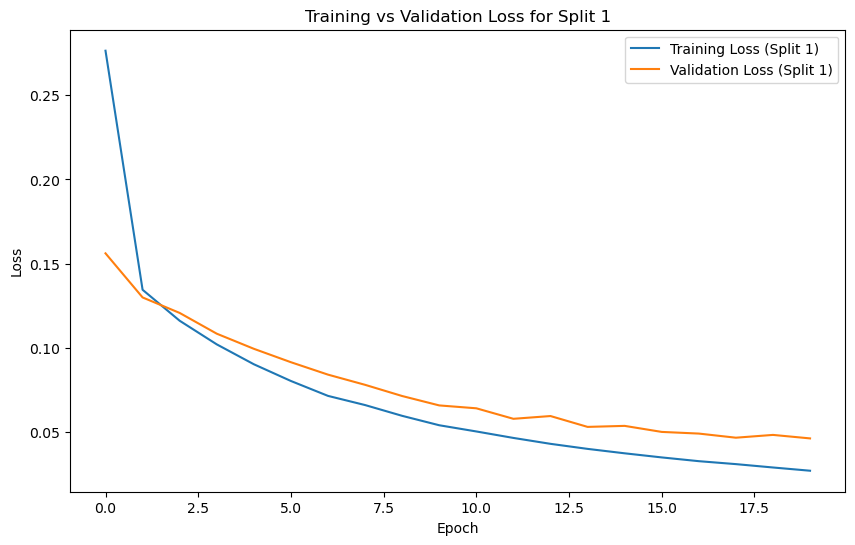

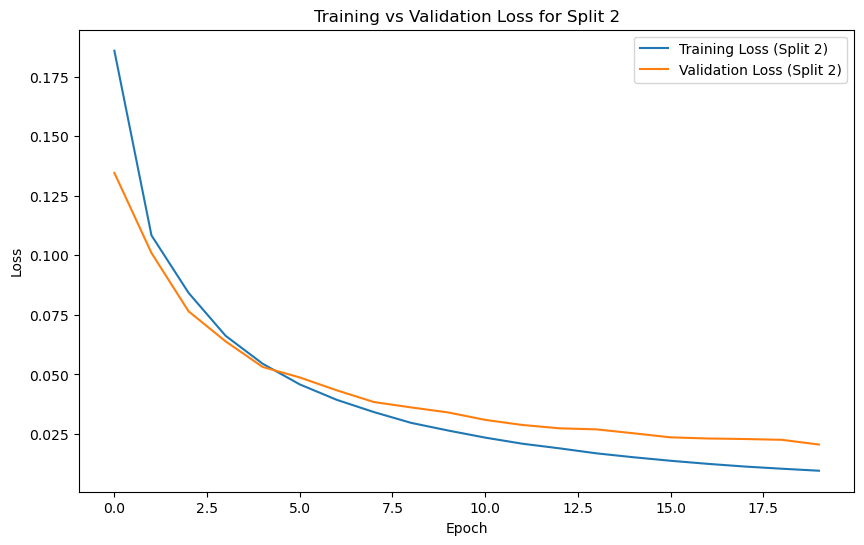

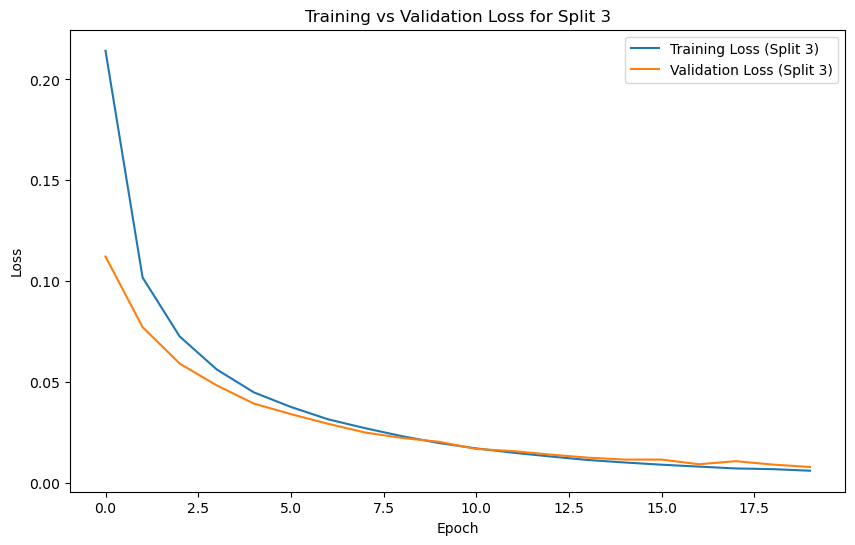

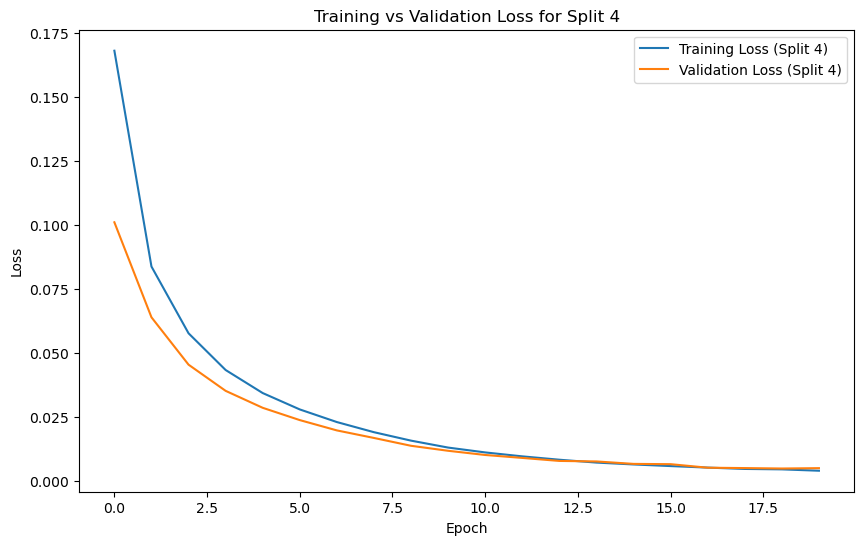

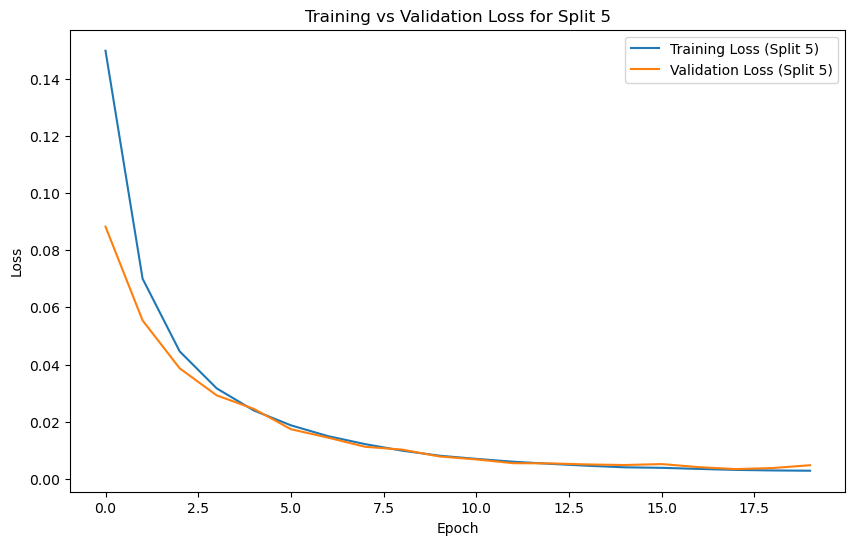

Epoch 1/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 19s 77ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 2/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 20s 77ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 3/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 4/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 19s 77ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 5/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 21s 77ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 6/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - loss: 9.8229e-04 - val_loss: 0.0012
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0011
Final test loss: 0.0011384660610929132
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


Text(0, 0.5, 'Value')

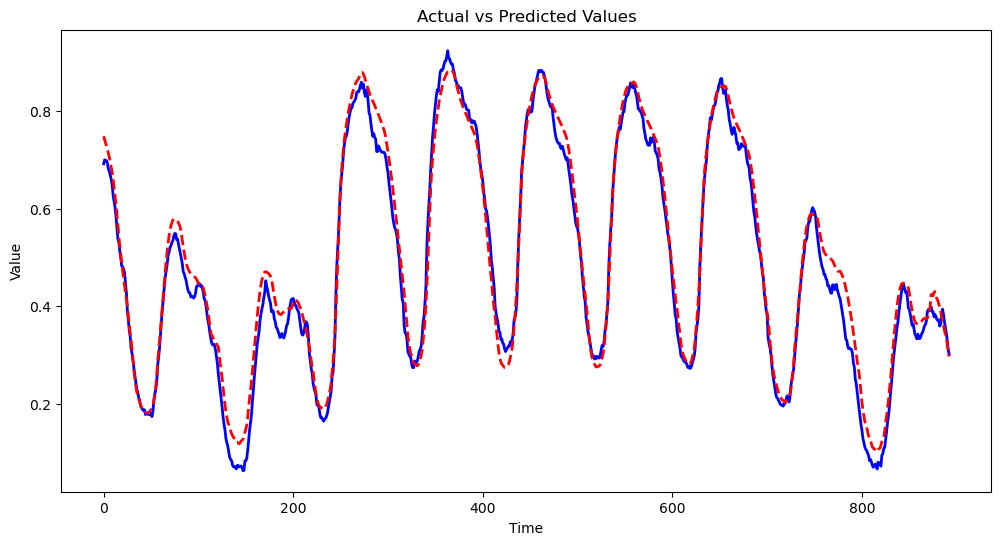

In [29]:

tscv = TimeSeriesSplit(n_splits=5)
split_results = []

train_losses_per_split = []
val_losses_per_split = []

for train_index, test_index in tscv.split(X_sequences):
    try:
        X_train, X_test = X_sequences[train_index], X_sequences[test_index]
        y_train, y_test = y_sequences[train_index], y_sequences[test_index]
    except IndexError as e:
        print(f"IndexError: {e}")
        print(f"train_index: {train_index}")
        print(f"test_index: {test_index}")
        print(f"X_sequences shape: {X_sequences.shape}")
        print(f"y_sequences shape: {y_sequences.shape}")
        break
    
    # Define the LSTM model
    model = Sequential()
   #model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]),
                   kernel_regularizer=l2(0.001)))
    #model.add(Dropout(0.2))
    model.add(Dropout(0.3))
    #model.add(LSTM(50, return_sequences=False))
    model.add(LSTM(32, return_sequences=False, kernel_regularizer=l2(0.001)))
    #model.add(Dropout(0.2))
    model.add(Dropout(0.3))
    #model.add(Dense(25))
    model.add(Dense(25, activation='relu', kernel_regularizer=l2(0.001))) 
    model.add(Dense(1))

    optimizer = Adam(learning_rate=0.0005)
    #model.compile(optimizer='adam', loss='mean_squared_error')
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    # Fit the model
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test),
                        callbacks=[early_stopping], verbose=1)
    
    # Evaluate the model
    # Collect loss for plotting
    train_losses_per_split.append(history.history['loss'])
    val_losses_per_split.append(history.history['val_loss'])
    
    loss = model.evaluate(X_test, y_test)
    split_results.append(loss)

# Average performance over all splits
average_loss = np.mean(split_results)
print(f'Average validation loss over all splits: {average_loss}')

# Plot training and validation losses across splits
for i in range(len(train_losses_per_split)):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses_per_split[i], label=f'Training Loss (Split {i+1})')
    plt.plot(val_losses_per_split[i], label=f'Validation Loss (Split {i+1})')
    plt.title(f'Training vs Validation Loss for Split {i+1}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Assuming the model performed well, we now train on the entire dataset (except the final test set)
train_size = int(len(X_sequences) * 0.9)
X_train_final, X_test_final = X_sequences[:train_size], X_sequences[train_size:]
y_train_final, y_test_final = y_sequences[:train_size], y_sequences[train_size:]

# Train the final model on all available data
model = Sequential()
#model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(32, return_sequences=True, input_shape=(X_train_final.shape[1], X_train_final.shape[2]),
               kernel_regularizer=l2(0.001)))
#model.add(Dropout(0.2))
model.add(Dropout(0.3))
#model.add(LSTM(50, return_sequences=False))
model.add(LSTM(32, return_sequences=False, kernel_regularizer=l2(0.001)))
#model.add(Dropout(0.2))
model.add(Dropout(0.3))
#model.add(Dense(25))
model.add(Dense(25, activation='relu', kernel_regularizer=l2(0.001))) 
model.add(Dense(1))

optimizer = Adam(learning_rate=0.0005)
#model.compile(optimizer='adam', loss='mean_squared_error')
model.compile(optimizer=optimizer, loss='mean_squared_error')

early_stopping_final = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_final.fit(X_train_final, y_train_final, epochs=20, batch_size=32, validation_data=(X_test_final, y_test_final),
                callbacks=[early_stopping_final], verbose=1)

# Final evaluation
final_loss = model_final.evaluate(X_test_final, y_test_final)
print(f'Final test loss: {final_loss}')

y_pred = model_final.predict(X_test_final)
#print(y_pred)
#y_pred = y_pred.flatten()
#print(y_pred)
# If your data was normalized, don't forget to inverse-transform y_pred and y_test_final back to original scale
# Assuming you used MinMaxScaler or similar normalization technique
# Example:
# y_pred = scaler.inverse_transform(y_pred)
# y_test_final = scaler.inverse_transform(y_test_final)

# Plotting actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_final, label='Actual Values', color='blue', linewidth=2)
plt.plot(y_pred, label='Predicted Values', color='red', linewidth=2, linestyle='--')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')


In [36]:


y_pred_2024 = model_final.predict(X_sequences)

69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step


Text(0, 0.5, 'Value')

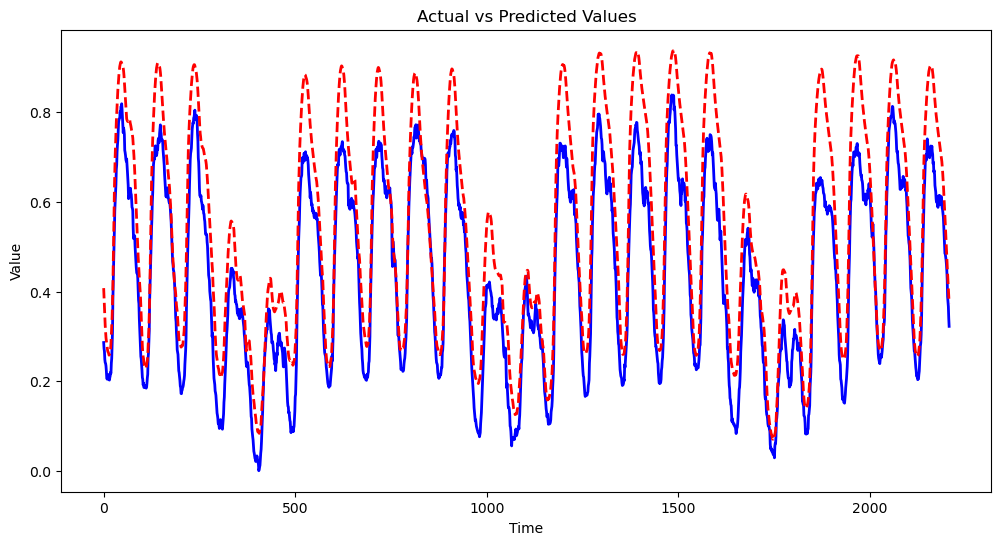

In [39]:
plt.figure(figsize=(12, 6))
plt.plot(y_sequences, label='Actual Values', color='blue', linewidth=2)
plt.plot(y_pred_2024, label='Predicted Values', color='red', linewidth=2, linestyle='--')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
